# Event Detection Via Social Media Data
----
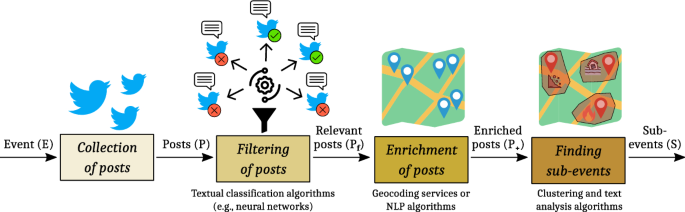

```
[Belcastro, L., Marozzo, F., Talia, D. et al. Using social media for sub-event detection during disasters. J Big Data 8, 79 (2021). https://doi.org/10.1186/s40537-021-00467-1]

```




## Table of Content

1. **Introduction**

   * Overview of the dataset
   * Purpose and objectives

2. **Background**

   * Event detection on Twitter
   * Challenges in creating event detection corpora
   * Importance of this dataset for research

3. **Dataset Overview**

   * Structure of the dataset
   * Key features (tweets, event annotations, etc.)
   * Sample data exploration

4. **Data Preprocessing**

   * Handling missing data
   * Cleaning and filtering data
   * Feature extraction and transformation

5. **Exploratory Data Analysis (EDA)**

   * Distribution of events in the dataset
   * Frequency of tweets by event
   * Top hashtags and entities in events
   * Visualizing tweet data (e.g., word clouds, graphs)

6. **Event Detection in Twitter**

   * Understanding the definition of events
   * Applying basic event detection methods

7. **Data Visualizations**

   * Graphs and plots to visualize relationships between entities, hashtags, and events
   * Network visualizations (e.g., Tweet and user interactions)

8. **Conclusion**

   * Key insights from the data analysis
   * Potential applications of event detection models
   * Next steps in research

9. **References**

   * Academic papers, tools, and methodologies used

## Introduction

##Data Loading

In [29]:
#@title Fix Dependency Issue
# Uninstall potentially conflicting versions first
# !pip uninstall -y numpy scipy gensim fasttext bertopic laserembeddings sentence-transformers

# !pip install numpy==1.26.4 scipy=
# !pip install gensim
# !pip install fasttext
# !pip install laserembeddings
!pip install bertopic
!pip install sentence-transformers


In [30]:
#@title Install Packages
# !pip install arabic-reshaper python-bidi
# !pip install ar_wordcloud
# !pip install transformers
# # !pip install stanza --quiet
# !pip install -U bertopic
# !pip install -U sentence-transformers
# !pip install -U scikit-learn
# !pip install -U arabert

# import nltk
# # import stanza

# nltk.download('stopwords')
# from nltk.corpus import stopwords

# arabic_stopwords = set(stopwords.words('arabic'))

# english_stopwords = set(stopwords.words('english'))
# combined_stopwords = arabic_stopwords.union(english_stopwords)

# # Download Arabic model once
# # stanza.download('ar', verbose=False)

# # Initialize pipeline for Arabic with NER
# # nlp = stanza.Pipeline('ar', processors='tokenize,ner', use_gpu=True)


In [31]:
#@title import packages
import numpy as np
import requests
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import re
import ast

# For reproducibility
np.random.seed(42)

import pandas as pd
#@title import packages
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
# import arabic_reshaper
# from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt
# import arabic_reshaper
# from bidi.algorithm import get_display
from collections import Counter
import ast
# import arabic_reshaper
# from bidi.algorithm import get_display
# from ar_wordcloud import ArabicWordCloud

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import networkx as nx


In [32]:
#@title uitlities
import re

def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+', '', text)                # remove mentions
    text = re.sub(r'#\w+', '', text)                # remove hashtags
    text = re.sub(r'[^ء-يa-zA-Z0-9\s]', ' ', text) # keep Arabic letters, Latin letters, numbers, and spaces only
    text = re.sub(r'\s+', ' ', text)                 # remove extra whitespace
    return text.strip()

def extract_entities_stanza(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities




In [33]:
# @title Define Constants
urls = [
    "https://raw.githubusercontent.com/HasanKhadd0ur/SocialED_datasets/main/npy_data/Event2012.npy"
]
from google.colab import drive
drive.mount('/content/drive')

columns=[ 'tweet_id', 'text', 'event_id', 'words', 'filtered_words', 'entities', 'user_id', 'created_at', 'urls', 'hashtags', 'user_mentions']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
#@title process data
# import os
# import pandas as pd

# # Define folder path in your Drive
# folder_path = '/content/drive/MyDrive/Events'

# # List CSV files only
# csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
# dataframes = []

# for label, filename in enumerate(csv_files):
#     file_path = os.path.join(folder_path, filename)
#     try:
#         df = pd.read_csv(file_path)
#         df['event_label'] = label  # Numeric label for each file
#         df['event_filename'] = filename  # Optional: store filename
#         dataframes.append(df)
#     except Exception as e:
#         print(f"Error reading {filename}: {e}")
# merged_df = pd.concat(dataframes, ignore_index=True)

# # Optional: Save to Drive or download
# merged_df.to_csv('/content/drive/MyDrive/merged_labeled_events.csv', index=False)

In [35]:
#@title Load dataset
df = pd.read_csv("/content/drive/MyDrive/merged_labeled_events.csv")

In [36]:
#@title Data Columns
df.columns

Index(['Tweet ID', 'Tweet Text', 'Type', 'Author Name', 'Author Username',
       'Creation Time', 'Reply Count', 'Retweet Count', 'Quote Count',
       'Like Count', 'View Count', 'Bookmark Count', 'Language',
       'Possibly Sensitive', 'Source', 'Hashtags', 'Tweet URL', 'Media Type',
       'Media URLs', 'External URLs', 'event_label', 'event_filename',
       'Hashtags_str', 'Old Tweet Text', 'Named Entities', 'Date', 'date'],
      dtype='object')

In [37]:
# @title Ensure Type
# Ensure datetime format
df['Creation Time'] = pd.to_datetime(df['Creation Time'])
# Extract just the date part
df['date'] = df['Creation Time'].dt.date

import ast

def entities_to_list(entities_str):
    if isinstance(entities_str, str):
        try:
            # Safely evaluate the string to a Python list
            entities = ast.literal_eval(entities_str)
            # Ensure it's a list and strip whitespace from each entity
            if isinstance(entities, list):
                return [e.strip() for e in entities]
            else:
                return []
        except (ValueError, SyntaxError):
            return []
    else:
        return []

# Apply to the Named Entities column
df['Named Entities'] = df['Named Entities'].apply(entities_to_list)



In [38]:
#@title Ensure hashtags are stored as lists instead of comma-separated strings
# def convert_hashtags_to_list(value):
#     if isinstance(value, str):
#         return [tag.strip() for tag in value.split(',') if tag.strip()]
#     return []

# df['Hashtags'] = df['Hashtags'].apply(convert_hashtags_to_list)
# Convert the string of hashtags separated by commas into a list, handling NaN

def hashtags_to_list(hstring):
    if isinstance(hstring, str):
        # Split by comma, strip whitespace
      return [tag.strip().lstrip('#') for tag in hstring.split(',') if tag.strip()]

    else:
        # For NaN or missing values
        return []
df['Hashtags_str'] = df['Hashtags']

# Apply conversion to your hashtag column, e.g., 'Hashtags_str'
df['Hashtags'] = df['Hashtags'].apply(hashtags_to_list)



In [39]:
# @title Data shape
print(df.shape)


(6642, 27)


In [40]:
#@title Clean the tweet texts
df['Old Tweet Text'] = df['Tweet Text']
df['Tweet Text'] = df['Tweet Text'].apply(clean_tweet)


## BERTopic, With ARABERT Embedding

In [41]:
# @title Install  Arabert and BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Use Arabic sentence transformer model
embedding_model = SentenceTransformer("aubmindlab/bert-base-arabertv2")

# Create and fit BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, language="arabic")



In [42]:
#@title Embeddding the Tweets
tweets = df['Tweet Text'].tolist()
embeddings = embedding_model.encode(tweets, show_progress_bar=True)


Batches:   0%|          | 0/208 [00:00<?, ?it/s]

In [52]:
#@title Save the Embedding
# Convert to DataFrame
embedding_df = pd.DataFrame(embeddings)

# Save
embedding_df.to_csv("tweet_embeddings.csv", index=False)


In [44]:
#@title Fit the model the tweets
# tweets = df["Tweet Text"].tolist()
topics, probs = topic_model.fit_transform(tweets,embeddings)



In [45]:
#@title View topics
topic_info = topic_model.get_topic_info()
print(topic_info.head())



   Topic  Count                         Name  \
0     -1   2167              -1_من_في_عن_على   
1      0    240               0_عم_ما_يلي_بس   
2      1    210    1_بويضاني_عصام_كوهين_ايلي   
3      2    210  2_مجلس_العقوبات_ترامب_مندوب   
4      3    203  3_الطفلة_آية_بلوق_الزبلطاني   

                                      Representation  \
0  [من, في, عن, على, سوريا, لا, العقوبات, السورية...   
1     [عم, ما, يلي, بس, ياخور, مو, رح, شو, انو, حدا]   
2  [بويضاني, عصام, كوهين, ايلي, قضية, تجاهل, باسم...   
3  [مجلس, العقوبات, ترامب, مندوب, سوريا, الأمريكي...   
4  [الطفلة, آية, بلوق, الزبلطاني, العثور, أيام, س...   

                                 Representative_Docs  
0  [الاعتداء من قبل مجموعة مسلحة على محافظ الدكتو...  
1  [ما رح قلك قديشك سخيف على هالخبر بس رح قلك الح...  
2  [ماهو سبب تجاهل قضية عصام بويضاني هل تم بيعه ل...  
3  [المندوب الصيني في مجلس الأمن على المجتمع الدو...  
4  [العثور على الطفلة آية بلوق مقتولة في سوق الها...  


In [46]:
#@title Exclude the outlier topic -1
n_topics = len(set(topic_model.get_topics().keys())) - (1 if -1 in topic_model.get_topics() else 0)

print(f"Total number of topics (excluding outliers): {n_topics}")


Total number of topics (excluding outliers): 109


In [47]:
#@title Topic Coherence
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.corpora import Dictionary

# # Get topic words
# topics = topic_model.get_topics()
# top_words = [[word for word, _ in topic] for topic in topics.values()]

# # Prepare corpus and dictionary
# texts = [doc.split() for doc in tweets]
# dictionary = Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Compute coherence score
# coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_score = coherence_model.get_coherence()
# print(f"Topic Coherence Score (c_v): {coherence_score:.4f}")


In [48]:
# @title  visualize topics
topic_model.visualize_barchart(top_n_topics=10)


In [49]:
#@title Inter Topic Distance
topic_model.visualize_topics()


In [50]:
#@title Similarity Heat Map
topic_model.visualize_heatmap()


In [51]:
#@title Topics  Over Time
topics_over_time = topic_model.topics_over_time(tweets, df['date'].tolist(), topics)
topic_model.visualize_topics_over_time(topics_over_time)

## BERTopic, With LASER Embedding

In [55]:
# @title Install  mbert and BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Use Arabic sentence transformer model
embedding_model = SentenceTransformer("sentence-transformers/LaBSE")

# Create and fit BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, language="arabic")



modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
#@title Embeddding the Tweets
tweets = df['Tweet Text'].tolist()
embeddings = embedding_model.encode(tweets, show_progress_bar=True)


Batches:   0%|          | 0/208 [00:00<?, ?it/s]

In [ ]:
#@title fit the model

topics, probs = topic_model.fit_transform(tweets, embeddings)

print(f"Number of topics: {len(set(topics))}")


In [ ]:
#@title View topics
topic_info = topic_model.get_topic_info()
print(topic_info.head())



   Topic  Count                           Name  \
0     -1   2381             -1_من_في_سوريا_على   
1      0    231                 0_عم_ما_بس_يلي   
2      1    225      1_بويضاني_عصام_كوهين_ايلي   
3      2    206    2_الطفلة_آية_بلوق_الزبلطاني   
4      3    132  3_الأمن_كميات_الداخلي_الأسلحة   

                                      Representation  \
0  [من, في, سوريا, على, عن, لا, العقوبات, مع, الس...   
1      [عم, ما, بس, يلي, ياخور, شو, رح, انو, مو, شي]   
2  [بويضاني, عصام, كوهين, ايلي, قضية, تجاهل, باسم...   
3  [الطفلة, آية, بلوق, الزبلطاني, العثور, أيام, س...   
4  [الأمن, كميات, الداخلي, الأسلحة, أمنية, ضبط, ا...   

                                 Representative_Docs  
0  [الاعتداء من قبل مجموعة مسلحة على محافظ السويد...  
1  [يلي عم ينكر الحقيقة بقضية الطفلة واضح إنه عاي...  
2  [ماهو سبب تجاهل قضية عصام بويضاني هل تم بيعه ل...  
3  [العثور على الطفلة آية بلوق مقتولة في سوق الها...  
4  [أطلقت قيادة الأمن الداخلي في حملة أمنية في من...  


In [ ]:
#@title Exclude the outlier topic -1
n_topics = len(set(topic_model.get_topics().keys())) - (1 if -1 in topic_model.get_topics() else 0)

print(f"Total number of topics (excluding outliers): {n_topics}")


Total number of topics (excluding outliers): 114


In [ ]:
#@title Topic Coherence
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Get topic words
topics = topic_model.get_topics()
top_words = [[word for word, _ in topic] for topic in topics.values()]

# Prepare corpus and dictionary
texts = [doc.split() for doc in tweets]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Compute coherence score
coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Topic Coherence Score (c_v): {coherence_score:.4f}")


Topic Coherence Score (c_v): 0.7831


In [ ]:
# @title  visualize topics
topic_model.visualize_barchart(top_n_topics=10)


In [ ]:
#@title Inter Topic Distance
topic_model.visualize_topics()


In [ ]:
#@title Similarity Heat Map
topic_model.visualize_heatmap()


In [ ]:
#@title Topics  Over Time
topics_over_time = topic_model.topics_over_time(tweets, df['date'].tolist(), topics)
topic_model.visualize_topics_over_time(topics_over_time)

## Tuning BERTopic

In [ ]:
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.metrics import pairwise_distances
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np

# Function to compute NPMI coherence
def compute_npmi_coherence(topic_model, texts):
    topics = topic_model.get_topics()
    topic_words = [[word for word, _ in topic[:10]] for topic in topics.values()]

    # Prepare for Gensim coherence
    tokenized = [text.split() for text in texts]
    dictionary = Dictionary(tokenized)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized]

    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokenized,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_npmi'
    )
    return coherence_model.get_coherence()

# Try different values for min_cluster_size
min_cluster_sizes = [5, 10, 15, 20, 25, 30]
coherence_scores = []


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.metrics import pairwise_distances
import numpy as np
from collections import Counter

# Function to compute NPMI coherence manually
def compute_npmi_coherence_manual(topic_model, texts):
    topics = topic_model.get_topics()
    topic_words = [[word for word, _ in topic[:10]] for topic in topics.values()]

    # Flatten the texts into a single list of words for easier counting
    all_words = [word for text in texts for word in text.split()]
    word_counts = Counter(all_words)
    total_word_count = sum(word_counts.values())

    coherence_scores_list = []

    for topic in topic_words:
        topic_coherence = 0
        num_word_pairs = 0
        for i in range(len(topic)):
            for j in range(i + 1, len(topic)):
                word1 = topic[i]
                word2 = topic[j]

                # Calculate co-occurrence count of word1 and word2 in texts
                co_occurrence_count = sum(1 for text in texts if word1 in text.split() and word2 in text.split())

                # Calculate occurrence count of word1 and word2
                count1 = word_counts.get(word1, 0)
                count2 = word_counts.get(word2, 0)

                # Calculate NPMI for the word pair
                if count1 > 0 and count2 > 0 and co_occurrence_count > 0:
                    npmi = np.log(co_occurrence_count * total_word_count / (count1 * count2)) / -np.log(co_occurrence_count / total_word_count)
                    topic_coherence += npmi
                    num_word_pairs += 1

        # Average the NPMI scores for the topic
        if num_word_pairs > 0:
            coherence_scores_list.append(topic_coherence / num_word_pairs)
        else:
            coherence_scores_list.append(0) # Assign 0 coherence if no word pairs

    # Average coherence across all topics
    if len(coherence_scores_list) > 0:
        return np.mean(coherence_scores_list)
    else:
        return 0 # Assign 0 overall coherence if no topics

# Try different values for min_cluster_size
min_cluster_sizes = [5, 10, 15, 20, 25, 30]
coherence_scores = []

In [ ]:

for size in min_cluster_sizes:
    print(f"Training BERTopic with min_cluster_size={size}")

    topic_model = BERTopic(
        embedding_model=None,  # Since you're using LASER externally
        hdbscan_model=None  # Let it create HDBSCAN with min_cluster_size
    )

    # Recreate HDBSCAN with desired min_cluster_size
    from hdbscan import HDBSCAN
    hdbscan_model = HDBSCAN(min_cluster_size=size, metric='euclidean', prediction_data=True)
    topic_model.hdbscan_model = hdbscan_model

    topics, _ = topic_model.fit_transform(tweets, embeddings)

    coherence = compute_npmi_coherence(topic_model, texts)
    print(f"Coherence (NPMI): {coherence:.4f}")
    coherence_scores.append(coherence)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(min_cluster_sizes, coherence_scores, marker='o')
plt.title("NPMI Coherence vs min_cluster_size")
plt.xlabel("min_cluster_size")
plt.ylabel("NPMI Coherence")
plt.grid(True)
plt.show()


Training BERTopic with min_cluster_size=5


NameError: name 'compute_npmi_coherence' is not defined

## Conclusion

In [ ]:
#@title Save the dataset
df.to_csv('/content/drive/MyDrive/cleaned_merged_labeled_events.csv', index=False)
df.to_csv('/content/drive/MyDrive/merged_labeled_events.csv', index=False)


## Refrences
